In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading all text files into numpy arrays

In [ ]:
focal_signals = []
non_focal_signals = []

path = "/content/drive/MyDrive/BERNBarcelona/"

for i in range(1, 3751):
    # Construct the filename
    filename = f"Data_F_Ind{i:04}.txt"
    file_path = path + filename

    # Load the data using comma as the delimiter
    signal = np.loadtxt(file_path, delimiter=',')
    focal_signals.append(signal)

for i in range(1, 3751):
    # Construct the filename
    filename = f"Data_N_Ind{i:04}.txt"
    file_path = path + filename

    # Load the data using comma as the delimiter
    signal = np.loadtxt(file_path, delimiter=',')
    non_focal_signals.append(signal)

Plotting the signals

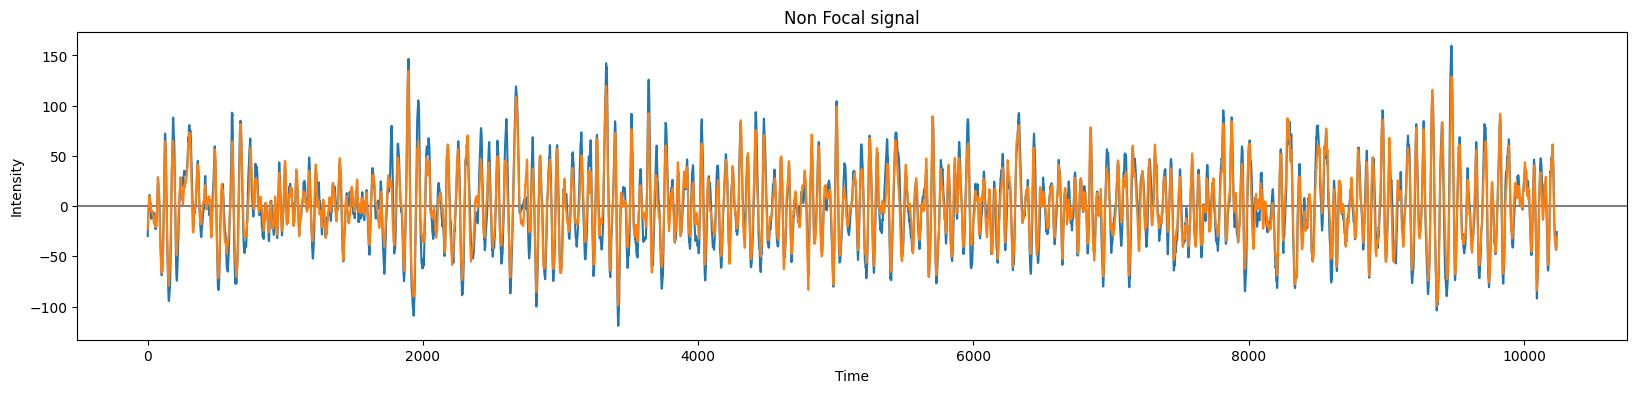

In [ ]:
# Extract the desired row as a pandas Series
row = non_focal_signals[0] # Non focal signal

# Plot the line chart
fig = plt.figure(figsize=(20,4))
plt.axhline(0, color='grey')
plt.plot(row)
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Non Focal signal')
plt.show()

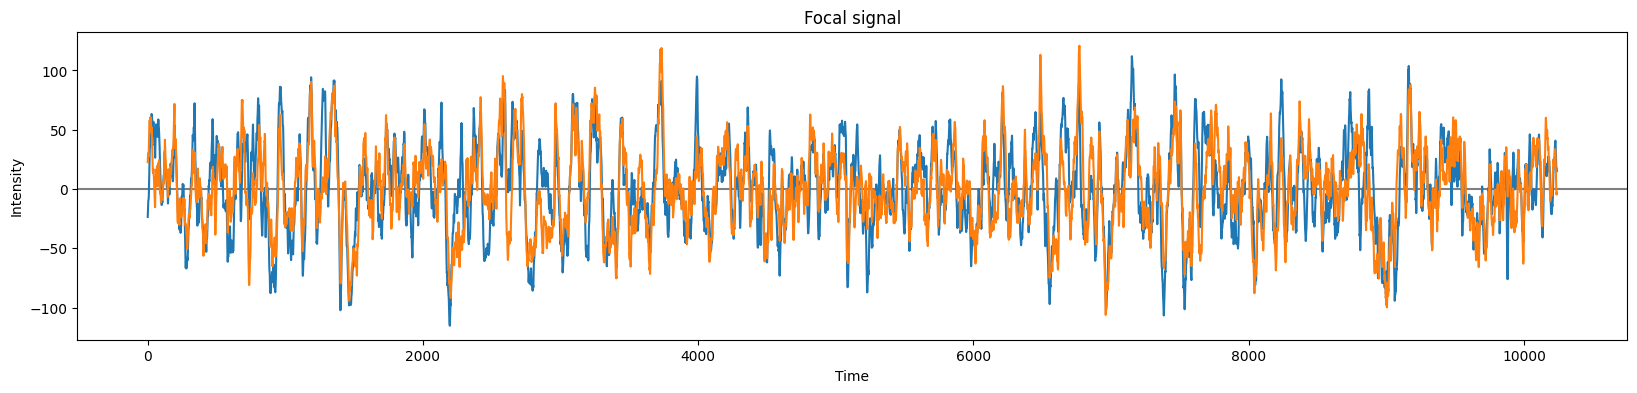

In [ ]:
# Extract the desired row as a pandas Series
row = focal_signals[0] #focal signal

# Plot the line chart
fig = plt.figure(figsize=(20,4))
plt.axhline(0, color='grey')
plt.plot(row)
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Focal signal')
plt.show()

Filtering signals with Butterworth bandpass filter

In [ ]:
from scipy.signal import butter, lfilter

eeg_signals = non_focal_signals + focal_signals

fs_original = 1024
fs_downsampled = 512
lowcut = 0.5
highcut = 150
order = 4

# Downsample the EEG signals to 512 Hz (if originally sampled at 1024 Hz)
# Replace 'fs_original' with the actual original sampling rate of the EEG signals
downsample_factor = fs_original // fs_downsampled
downsampled_eeg_signals = [signal[::downsample_factor] for signal in eeg_signals]

# Apply the filter to the downsampled data using lfilter
filtered_eeg_signals = []
for signal in downsampled_eeg_signals:
    # Compute the filter coefficients for the downsampled signal's sampling rate
    nyquist_downsampled = 0.5 * fs_downsampled
    low_downsampled = lowcut / nyquist_downsampled
    high_downsampled = highcut / nyquist_downsampled
    b_downsampled, a_downsampled = butter(order, [low_downsampled, high_downsampled], btype='band')

    # Apply the filter using lfilter
    filtered_signal = lfilter(b_downsampled, a_downsampled, signal)
    filtered_eeg_signals.append(filtered_signal)

# Rereference the signals against the median of all the channels
median_reference = np.median(filtered_eeg_signals, axis=0)
re_referenced_eeg_signals = [signal - median_reference for signal in filtered_eeg_signals]


In [ ]:
# converting into a numpy array
eeg_signals = np.array(re_referenced_eeg_signals)
print(eeg_signals.shape)

(7500, 5120, 2)


In [ ]:
# Create the labels
labels = np.zeros((eeg_signals.shape[0],), dtype=np.int32)
labels[:3750] = 0 # set the first 200 rows to class 0 -> (non focal signals)
labels[3750:] = 1 # set the next 200 rows to class 1 -> (focal signals)
print(labels.shape)

(7500,)


In [ ]:
# Shuffle the data and labels
perm = np.random.permutation(len(eeg_signals))
data = eeg_signals[perm]
labels = labels[perm]

# saving the shuffled data and labels as numpy arrays to a file
np.save("data.npy", data)
np.save("labels.npy",labels)

print(data)
print(labels)

[[[   3.99695696   13.51482187]
  [   4.05308535   12.35228925]
  [   2.610953      6.42693237]
  ...
  [  -1.96069423   -9.44015906]
  [  -2.23186245   -9.93321914]
  [  -3.60995754  -15.85461246]]

 [[   1.70426385    9.53718159]
  [   3.17213181   13.28195548]
  [   3.31361226   13.39062365]
  ...
  [  -3.9334218   -20.56072618]
  [  -4.15214129  -20.77814888]
  [  -4.23089991  -21.74048476]]

 [[  10.70166801   52.06007489]
  [   9.97759279   49.1280966 ]
  [   9.97550781   47.5469396 ]
  ...
  [  -7.88720948  -31.27016803]
  [  -7.06424214  -30.4910295 ]
  [  -6.67143607  -28.77968624]]

 ...

 [[   5.14443566   10.89389661]
  [   5.60514609   13.93796364]
  [   4.936334     12.57990364]
  ...
  [ -43.71243319 -150.32601924]
  [ -38.05182917 -125.34068193]
  [ -32.30937756 -102.50493214]]

 [[  12.21965516   47.67626229]
  [   8.53080364   33.8462071 ]
  [   6.64312435   27.75805659]
  ...
  [ -42.05815279 -143.74674247]
  [ -42.63026042 -144.65329174]
  [ -42.58457361 -144.740700

In [ ]:
import numpy as np

# Load data
data = np.load('data.npy')

# Load labels
labels = np.load('labels.npy')

# Split the data into training and test sets (80:20)
train_size = int(0.8 * len(data))
train_data, train_labels = data[:train_size], labels[:train_size]
test_data, test_labels = data[train_size:], labels[train_size:]

# Reshape the data for use with LSTM, GRU, and Conv1D models
# train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
# test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], train_data.shape[2]))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], test_data.shape[2]))

In [ ]:
train_data

array([[[  3.99695696,  13.51482187],
        [  4.05308535,  12.35228925],
        [  2.610953  ,   6.42693237],
        ...,
        [ -1.96069423,  -9.44015906],
        [ -2.23186245,  -9.93321914],
        [ -3.60995754, -15.85461246]],

       [[  1.70426385,   9.53718159],
        [  3.17213181,  13.28195548],
        [  3.31361226,  13.39062365],
        ...,
        [ -3.9334218 , -20.56072618],
        [ -4.15214129, -20.77814888],
        [ -4.23089991, -21.74048476]],

       [[ 10.70166801,  52.06007489],
        [  9.97759279,  49.1280966 ],
        [  9.97550781,  47.5469396 ],
        ...,
        [ -7.88720948, -31.27016803],
        [ -7.06424214, -30.4910295 ],
        [ -6.67143607, -28.77968624]],

       ...,

       [[  3.76494836,   5.88177846],
        [  1.52030328,  -4.99562933],
        [ -0.68343742, -15.30302689],
        ...,
        [ -3.67863465, -13.17708336],
        [ -4.29753553, -14.60247709],
        [ -3.85730748, -12.18147565]],

       [[  0.56

LSTM

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

In [ ]:
# Define the model architecture
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(train_data.shape[1], train_data.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = lstm_model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
188/188 [==============================] - 1815s 10s/step - loss: 0.6952 - accuracy: 0.5233 - val_loss: 0.6784 - val_accuracy: 0.5953
Epoch 2/10
188/188 [==============================] - 1807s 10s/step - loss: 0.6827 - accuracy: 0.5572 - val_loss: 0.6411 - val_accuracy: 0.6487
Epoch 3/10
188/188 [==============================] - 1793s 10s/step - loss: 0.6733 - accuracy: 0.5862 - val_loss: 0.6772 - val_accuracy: 0.5660
Epoch 4/10
188/188 [==============================] - 1796s 10s/step - loss: 0.6555 - accuracy: 0.6247 - val_loss: 0.6283 - val_accuracy: 0.6527
Epoch 5/10
188/188 [==============================] - 1795s 10s/step - loss: 0.6906 - accuracy: 0.5332 - val_loss: 0.6822 - val_accuracy: 0.5760
Epoch 6/10
188/188 [==============================] - 1789s 10s/step - loss: 0.6863 - accuracy: 0.5517 - val_loss: 0.6639 - val_accuracy: 0.6173
Epoch 7/10
188/188 [==============================] - 1789s 10s/step - loss: 0.6688 - accuracy: 0.5890 - val_loss: 0.6709 - val_ac

In [ ]:
# Print the model summary
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5120, 64)          17152     
                                                                 
 dropout (Dropout)           (None, 5120, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 50,241
Trainable params: 50,241
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(test_data, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Predict the test labels
test_pred = lstm_model.predict(test_data)
test_pred = (test_pred > 0.5)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_pred))

47/47 [==============================] - 77s 2s/step - loss: 0.6184 - accuracy: 0.6707
Test loss: 0.6184072494506836
Test accuracy: 0.6706666946411133
47/47 [==============================] - 76s 2s/step
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       740
           1       0.67      0.69      0.68       760

    accuracy                           0.67      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.67      0.67      0.67      1500



47/47 [==============================] - 74s 2s/step


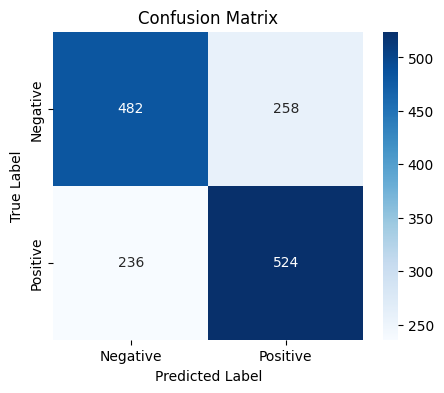

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels
test_pred = lstm_model.predict(test_data)
test_pred = (test_pred > 0.5)

# Get the confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

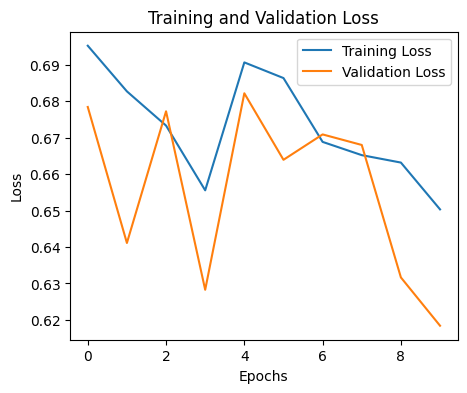

In [ ]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

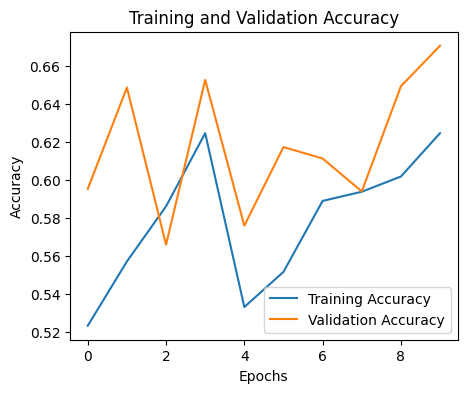

In [ ]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

47/47 [==============================] - 74s 2s/step


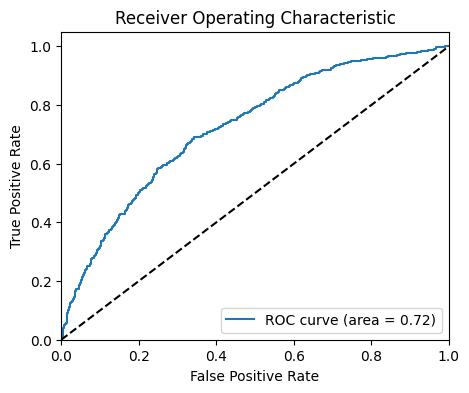

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = lstm_model.predict(test_data)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the model
lstm_model.save("detection_model.h5")

GRU

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

In [ ]:
# Build the model
model = Sequential()
model.add(GRU(64, input_shape=(train_data.shape[1], train_data.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
188/188 [==============================] - 1780s 9s/step - loss: 0.7021 - accuracy: 0.5213 - val_loss: 0.6819 - val_accuracy: 0.5553
Epoch 2/10
188/188 [==============================] - 1751s 9s/step - loss: 0.6983 - accuracy: 0.5230 - val_loss: 0.6836 - val_accuracy: 0.5507
Epoch 3/10
188/188 [==============================] - 1759s 9s/step - loss: 0.6911 - accuracy: 0.5378 - val_loss: 0.6837 - val_accuracy: 0.5613
Epoch 4/10
188/188 [==============================] - 1720s 9s/step - loss: 0.6833 - accuracy: 0.5698 - val_loss: 0.7052 - val_accuracy: 0.5293
Epoch 5/10
188/188 [==============================] - 1750s 9s/step - loss: 0.6807 - accuracy: 0.5630 - val_loss: 0.6783 - val_accuracy: 0.5653
Epoch 6/10
188/188 [==============================] - 1757s 9s/step - loss: 0.6851 - accuracy: 0.5563 - val_loss: 0.6627 - val_accuracy: 0.5953
Epoch 7/10
188/188 [==============================] - 1753s 9s/step - loss: 0.6661 - accuracy: 0.5892 - val_loss: 0.6341 - val_accuracy:

In [ ]:
# Print the model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5120, 64)          13056     
                                                                 
 dropout_2 (Dropout)         (None, 5120, 64)          0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,497
Trainable params: 22,497
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(test_data)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, np.round(predictions)))

47/47 - 56s - loss: 0.6954 - accuracy: 0.5180 - 56s/epoch - 1s/step
Test loss: 0.6954185962677002
Test accuracy: 0.5180000066757202
47/47 [==============================] - 57s 1s/step
              precision    recall  f1-score   support

           0       0.54      0.16      0.24       740
           1       0.51      0.87      0.65       760

    accuracy                           0.52      1500
   macro avg       0.53      0.51      0.44      1500
weighted avg       0.53      0.52      0.45      1500



47/47 [==============================] - 56s 1s/step


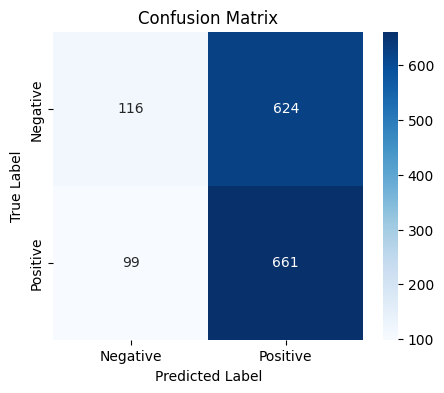

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels
test_pred = model.predict(test_data)
test_pred = (test_pred > 0.5)

# Get the confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

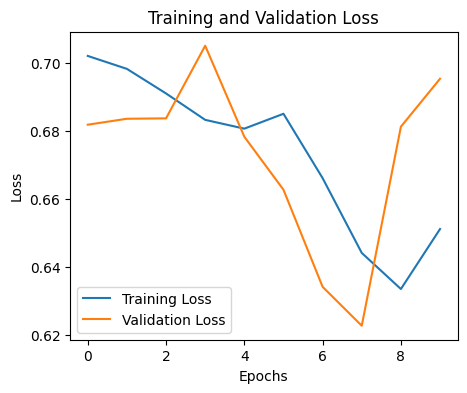

In [ ]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

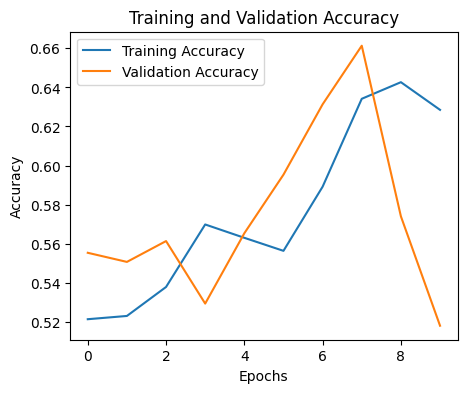

In [ ]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

47/47 [==============================] - 55s 1s/step


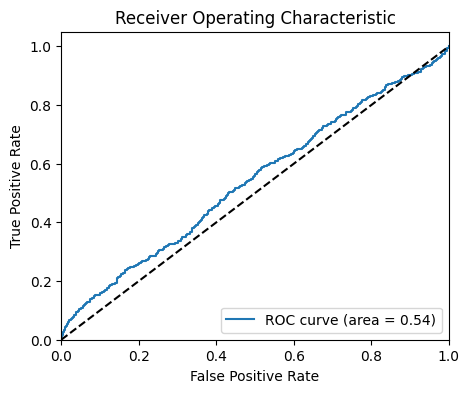

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = model.predict(test_data)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

1D CNN

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [ ]:
# Define the input shape
input_shape = (train_data.shape[1], train_data.shape[2])

# Define the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))

Epoch 1/20
188/188 [==============================] - 24s 113ms/step - loss: 9.6618 - accuracy: 0.5163 - val_loss: 3.9010 - val_accuracy: 0.5053
Epoch 2/20
188/188 [==============================] - 21s 110ms/step - loss: 1.2496 - accuracy: 0.6403 - val_loss: 2.0109 - val_accuracy: 0.5327
Epoch 3/20
188/188 [==============================] - 20s 108ms/step - loss: 0.7013 - accuracy: 0.7283 - val_loss: 2.3104 - val_accuracy: 0.5300
Epoch 4/20
188/188 [==============================] - 19s 103ms/step - loss: 0.5813 - accuracy: 0.7683 - val_loss: 2.6312 - val_accuracy: 0.5193
Epoch 5/20
188/188 [==============================] - 21s 114ms/step - loss: 0.4975 - accuracy: 0.7983 - val_loss: 1.7392 - val_accuracy: 0.5620
Epoch 6/20
188/188 [==============================] - 21s 110ms/step - loss: 0.3450 - accuracy: 0.8525 - val_loss: 1.6397 - val_accuracy: 0.5607
Epoch 7/20
188/188 [==============================] - 21s 110ms/step - loss: 0.2454 - accuracy: 0.9012 - val_loss: 1.6739 - val_ac

In [ ]:
# Print the model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5118, 32)          224       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2559, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 81888)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 81889     
                                                                 
Total params: 82,113
Trainable params: 82,113
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(test_data)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, np.round(predictions)))

47/47 - 1s - loss: 2.9251 - accuracy: 0.5507 - 1s/epoch - 28ms/step
Test loss: 2.9251458644866943
Test accuracy: 0.5506666898727417
47/47 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       740
           1       0.55      0.59      0.57       760

    accuracy                           0.55      1500
   macro avg       0.55      0.55      0.55      1500
weighted avg       0.55      0.55      0.55      1500



47/47 [==============================] - 2s 51ms/step


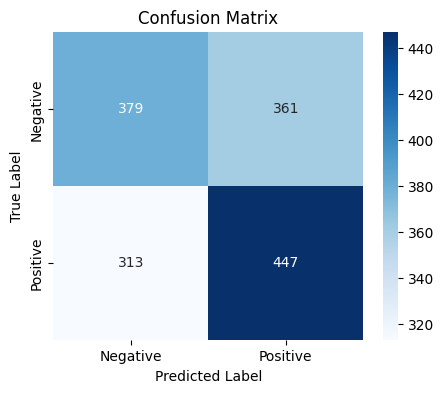

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels
test_pred = model.predict(test_data)
test_pred = (test_pred > 0.5)

# Get the confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

LSTM-2 (recurrent regulariser)

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
# from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [ ]:
# LSTM with recurrent regulariser
# Model architecture with L2 regularization and recurrent dropout

lstm2_model = Sequential()
lstm2_model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), input_shape=(train_data.shape[1], train_data.shape[2])))
lstm2_model.add(Dropout(0.2))
lstm2_model.add(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
lstm2_model.add(Dropout(0.2))
lstm2_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = lstm2_model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
188/188 [==============================] - 64s 283ms/step - loss: 1.3036 - accuracy: 0.5197 - val_loss: 0.7776 - val_accuracy: 0.5047
Epoch 2/10
188/188 [==============================] - 56s 300ms/step - loss: 0.7330 - accuracy: 0.5312 - val_loss: 0.7117 - val_accuracy: 0.5007
Epoch 3/10
188/188 [==============================] - 58s 308ms/step - loss: 0.7028 - accuracy: 0.5367 - val_loss: 0.6968 - val_accuracy: 0.5427
Epoch 4/10
188/188 [==============================] - 52s 275ms/step - loss: 0.6963 - accuracy: 0.5412 - val_loss: 0.6938 - val_accuracy: 0.5447
Epoch 5/10
188/188 [==============================] - 53s 281ms/step - loss: 0.6934 - accuracy: 0.5460 - val_loss: 0.6920 - val_accuracy: 0.5327
Epoch 6/10
188/188 [==============================] - 56s 299ms/step - loss: 0.6931 - accuracy: 0.5430 - val_loss: 0.6918 - val_accuracy: 0.5367
Epoch 7/10
188/188 [==============================] - 52s 274ms/step - loss: 0.6941 - accuracy: 0.5373 - val_loss: 0.6937 - val_ac

In [ ]:
# Print the model summary
print(lstm2_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5120, 64)          17152     
                                                                 
 dropout (Dropout)           (None, 5120, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 50,241
Trainable params: 50,241
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Evaluate the model
loss, accuracy = lstm2_model.evaluate(test_data, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Predict the test labels
test_pred = lstm2_model.predict(test_data)
test_pred = (test_pred > 0.5)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_pred))

47/47 [==============================] - 5s 105ms/step - loss: 0.6935 - accuracy: 0.5320
Test loss: 0.6934905648231506
Test accuracy: 0.5320000052452087
47/47 [==============================] - 6s 117ms/step
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       740
           1       0.54      0.50      0.52       760

    accuracy                           0.53      1500
   macro avg       0.53      0.53      0.53      1500
weighted avg       0.53      0.53      0.53      1500



47/47 [==============================] - 5s 100ms/step


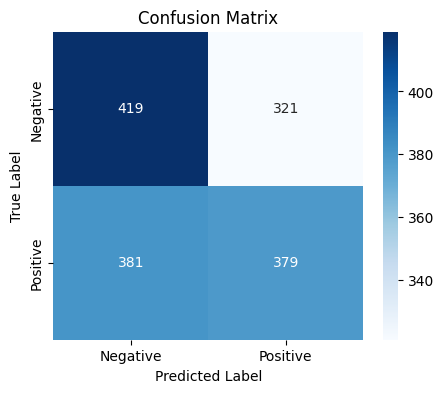

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels
test_pred = lstm2_model.predict(test_data)
test_pred = (test_pred > 0.5)

# Get the confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

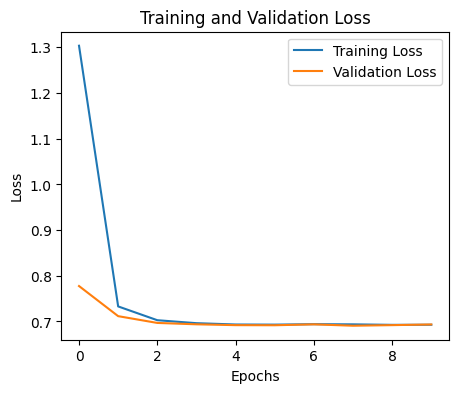

In [ ]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

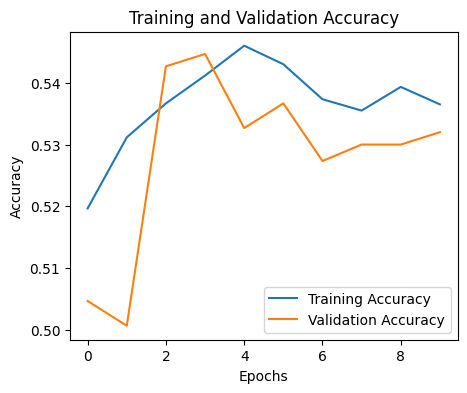

In [ ]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

47/47 [==============================] - 6s 120ms/step


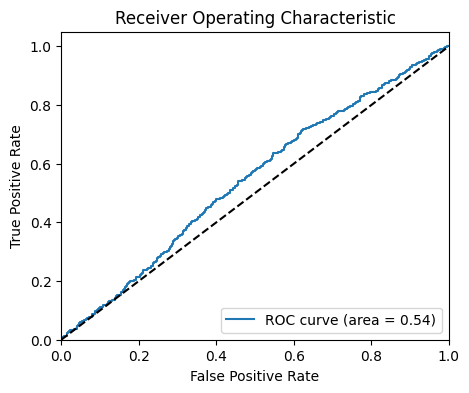

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = lstm2_model.predict(test_data)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

LSTM-3 (increased no. of units)

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [ ]:
# increasing no. of LSTM units 64 to 128
# model architecture
lstm3_model = Sequential()
lstm3_model.add(LSTM(128, return_sequences=True, input_shape=(train_data.shape[1], train_data.shape[2])))
lstm3_model.add(Dropout(0.2))
lstm3_model.add(LSTM(128))
lstm3_model.add(Dropout(0.2))
lstm3_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm3_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = lstm3_model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
188/188 [==============================] - 67s 333ms/step - loss: 0.6927 - accuracy: 0.5430 - val_loss: 0.6876 - val_accuracy: 0.5527
Epoch 2/10
188/188 [==============================] - 70s 370ms/step - loss: 0.6743 - accuracy: 0.5867 - val_loss: 0.6645 - val_accuracy: 0.6073
Epoch 3/10
188/188 [==============================] - 61s 325ms/step - loss: 0.6528 - accuracy: 0.6212 - val_loss: 0.6772 - val_accuracy: 0.5720
Epoch 4/10
188/188 [==============================] - 61s 324ms/step - loss: 0.6711 - accuracy: 0.5843 - val_loss: 0.6578 - val_accuracy: 0.6193
Epoch 5/10
188/188 [==============================] - 60s 320ms/step - loss: 0.6547 - accuracy: 0.6198 - val_loss: 0.6667 - val_accuracy: 0.6200
Epoch 6/10
188/188 [==============================] - 63s 334ms/step - loss: 0.6385 - accuracy: 0.6402 - val_loss: 0.6690 - val_accuracy: 0.5987
Epoch 7/10
188/188 [==============================] - 65s 343ms/step - loss: 0.6335 - accuracy: 0.6468 - val_loss: 0.6739 - val_ac

In [ ]:
# Print the model summary
print(lstm3_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5120, 128)         67072     
                                                                 
 dropout_2 (Dropout)         (None, 5120, 128)         0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Evaluate the model
loss, accuracy = lstm3_model.evaluate(test_data, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Predict the test labels
test_pred = lstm3_model.predict(test_data)
test_pred = (test_pred > 0.5)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_pred))

47/47 [==============================] - 6s 115ms/step - loss: 0.6243 - accuracy: 0.6633
Test loss: 0.6243450045585632
Test accuracy: 0.6633333563804626
47/47 [==============================] - 6s 111ms/step
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       740
           1       0.64      0.76      0.70       760

    accuracy                           0.66      1500
   macro avg       0.67      0.66      0.66      1500
weighted avg       0.67      0.66      0.66      1500



47/47 [==============================] - 6s 119ms/step


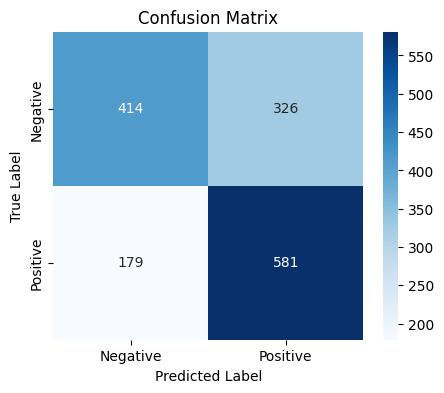

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels
test_pred = lstm3_model.predict(test_data)
test_pred = (test_pred > 0.5)

# Get the confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

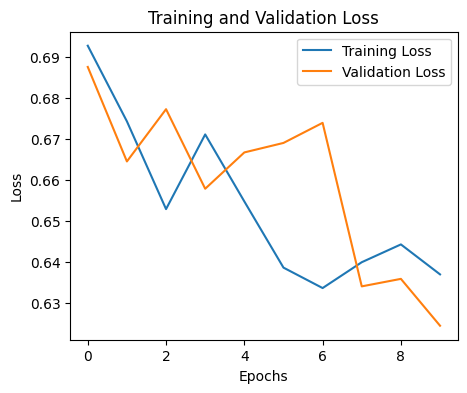

In [ ]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

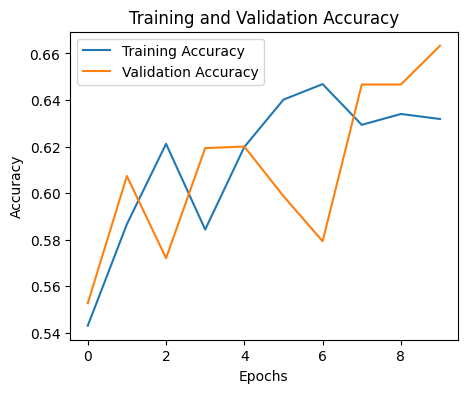

In [ ]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

47/47 [==============================] - 8s 162ms/step


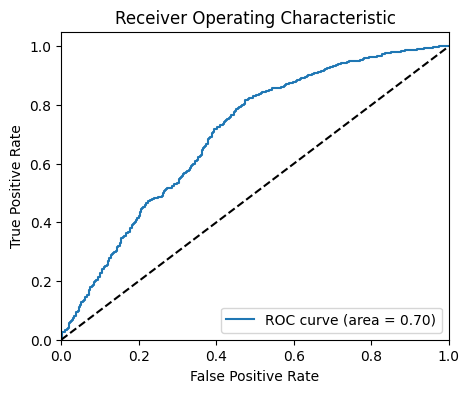

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = lstm3_model.predict(test_data)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

GRU-2

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

In [ ]:
# Model with increased number of GRU units
model = Sequential()
model.add(GRU(128, input_shape=(train_data.shape[1], train_data.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
188/188 [==============================] - 66s 322ms/step - loss: 0.7155 - accuracy: 0.5065 - val_loss: 0.6871 - val_accuracy: 0.5533
Epoch 2/10
188/188 [==============================] - 54s 289ms/step - loss: 0.7032 - accuracy: 0.5275 - val_loss: 0.6925 - val_accuracy: 0.5267
Epoch 3/10
188/188 [==============================] - 55s 291ms/step - loss: 0.6882 - accuracy: 0.5620 - val_loss: 0.6847 - val_accuracy: 0.5553
Epoch 4/10
188/188 [==============================] - 55s 292ms/step - loss: 0.6874 - accuracy: 0.5677 - val_loss: 0.6596 - val_accuracy: 0.6133
Epoch 5/10
188/188 [==============================] - 55s 292ms/step - loss: 0.6696 - accuracy: 0.5780 - val_loss: 0.6814 - val_accuracy: 0.5487
Epoch 6/10
188/188 [==============================] - 55s 292ms/step - loss: 0.6663 - accuracy: 0.6060 - val_loss: 0.7592 - val_accuracy: 0.5060
Epoch 7/10
188/188 [==============================] - 55s 292ms/step - loss: 0.6722 - accuracy: 0.5933 - val_loss: 0.7052 - val_ac

In [ ]:
# Print the model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5120, 128)         50688     
                                                                 
 dropout_4 (Dropout)         (None, 5120, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 88,001
Trainable params: 88,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(test_data)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, np.round(predictions)))

47/47 - 6s - loss: 0.7676 - accuracy: 0.5133 - 6s/epoch - 120ms/step
Test loss: 0.7675672173500061
Test accuracy: 0.5133333206176758
47/47 [==============================] - 5s 102ms/step
              precision    recall  f1-score   support

           0       0.78      0.02      0.04       740
           1       0.51      0.99      0.67       760

    accuracy                           0.51      1500
   macro avg       0.64      0.51      0.36      1500
weighted avg       0.64      0.51      0.36      1500



47/47 [==============================] - 5s 116ms/step


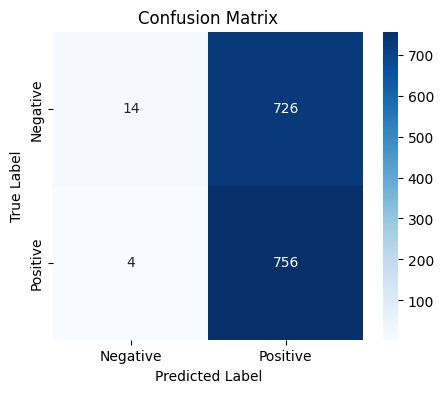

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels
test_pred = model.predict(test_data)
test_pred = (test_pred > 0.5)

# Get the confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

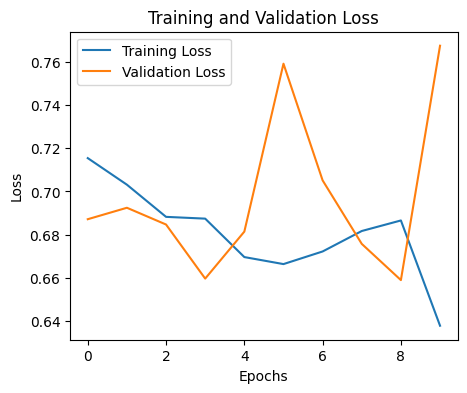

In [ ]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

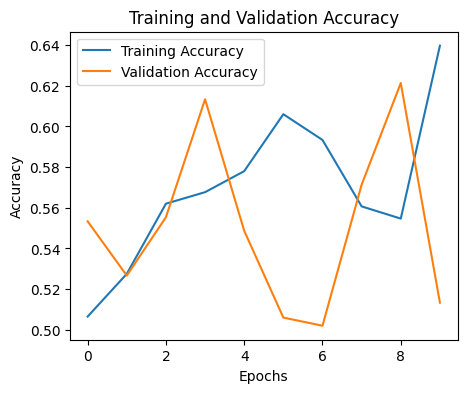

In [ ]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

47/47 [==============================] - 5s 104ms/step


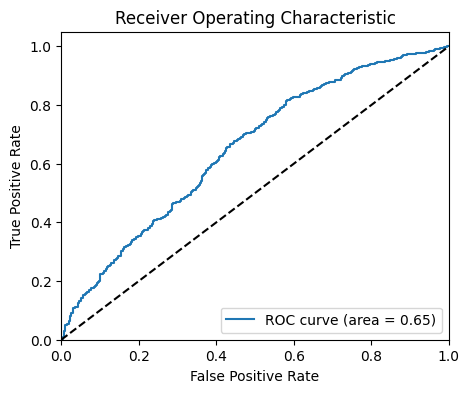

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = model.predict(test_data)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

BiLSTM

In [ ]:
import tensorflow
from tensorflow import keras
from keras.layers import Bidirectional, Dropout, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [ ]:
# Define the model architecture
Bilstm_model = Sequential()
Bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(train_data.shape[1], train_data.shape[2])))
Bilstm_model.add(Dropout(0.2))
Bilstm_model.add(Bidirectional(LSTM(64)))
Bilstm_model.add(Dropout(0.2))
Bilstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
Bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = Bilstm_model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
188/188 [==============================] - 3736s 20s/step - loss: 0.6870 - accuracy: 0.5622 - val_loss: 0.6704 - val_accuracy: 0.5933
Epoch 2/10
188/188 [==============================] - 3624s 19s/step - loss: 0.6565 - accuracy: 0.6153 - val_loss: 0.6815 - val_accuracy: 0.5587
Epoch 3/10
188/188 [==============================] - 3645s 19s/step - loss: 0.6635 - accuracy: 0.6017 - val_loss: 0.6617 - val_accuracy: 0.6240
Epoch 4/10
188/188 [==============================] - 3755s 20s/step - loss: 0.6505 - accuracy: 0.6245 - val_loss: 0.6685 - val_accuracy: 0.5967
Epoch 5/10
188/188 [==============================] - 3747s 20s/step - loss: 0.6344 - accuracy: 0.6527 - val_loss: 0.6533 - val_accuracy: 0.6153
Epoch 6/10
 47/188 [======>.......................] - ETA: 45:05 - loss: 0.6260 - accuracy: 0.6456

In [ ]:
# Print the model summary
print(Bilstm_model.summary())

In [ ]:
# Evaluate the model
loss, accuracy = Bilstm_model.evaluate(test_data, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Predict the test labels
test_pred = Bilstm_model.predict(test_data)
test_pred = (test_pred > 0.5)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_pred))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels
test_pred = Bilstm_model.predict(test_data)
test_pred = (test_pred > 0.5)

# Get the confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = Bilstm_model.predict(test_data)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()